In [176]:
#!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
#!pip3 install matplotlib
#!pip3 install matplotlib

In [177]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from torch.utils import data
import matplotlib.pyplot as plt
import pandas as pd

In [178]:
# Here you must specify the cause_id you want to train on
"""
cause_id columns meaning:
  "508","Chronic respiratory diseases"
  "509","Chronic obstructive pulmonary disease"
  "510","Pneumoconiosis"
  "511","Silicosis"
  "512","Asbestosis"
  "513","Coal workers pneumoconiosis"
  "514","Other pneumoconiosis"
  "515","Asthma"
  "516","Interstitial lung disease and pulmonary sarcoidosis"
  "520","Other chronic respiratory diseases"
  "-1","All causes"
"""
cause_id = 515

In [179]:
torch.manual_seed(42) # Setting the seed
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if torch.cuda.is_available(): 
  torch.cuda.manual_seed(42)
  torch.cuda.manual_seed_all(42)
print("Current device is {}".format(device))

Current device is cpu


In [180]:
class AirDataSet(data.Dataset):

  def __init__(self):
    super().__init__()
    file_path = 'training_data/cause_id_{}.csv'.format(cause_id)
    if (cause_id == -1):
      file_path = 'training_data/all_data.csv'
    training_df = pd.read_csv(file_path,
      dtype={
        'parameter_85101': 'float32',
        'parameter_88101': 'float32',
        'parameter_44201': 'float32',
        'parameter_42602': 'float32',
        'parameter_42401': 'float32',
        'parameter_42101': 'float32',
        'mortality_rate': 'float32',
        'cause_id': 'float32',
      })
    training_df = training_df.drop(columns=['fips', 'year'])
    if (cause_id != -1):
      training_df = training_df.drop(columns=['cause_id'])
    
    print(training_df.dtypes)


    # Use only the first 1000 rows for training
    # training_df = training_df[:1000]

    # For each row we have the following columns corresponding to features:
    # -parameter_85101
    # -parameter_88101
    # -parameter_44201
    # -parameter_42602
    # -parameter_42401
    # -parameter_42101
    # -cause_id (if cause_id != -1)

    # And the following columns corresponding to labels:
    # -rate

    # We want to predict the rate based on the parameters
    self.data = torch.from_numpy(training_df.drop(columns=['mortality_rate']).to_numpy())
    self.label = torch.from_numpy(training_df[['mortality_rate']].to_numpy())

    # Normalize the data based on mean and variance
    print("Data mean: {}, Data std: {}".format(self.data.mean(dim=0), self.data.std(dim=0)))

    self.data = (self.data - self.data.mean(dim=0)) / self.data.std(dim=0)


  def __len__(self):
    # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
    return self.data.shape[0]

  def __getitem__(self, idx):
    # Return the idx-th data point of the dataset
    # If we have multiple things to return (data point and label), we can return them as tuple
    data_point = self.data[idx]
    data_label = self.label[idx]
    return data_point, data_label

In [181]:
class SVM(nn.Module):
    def __init__(self):
        super(SVM, self).__init__()
        self.linear = nn.Linear(6, 1)

    def forward(self, x):
        return self.linear(x)

In [182]:
dataset = AirDataSet()

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

parameter_85101    float32
parameter_88101    float32
parameter_44201    float32
parameter_42602    float32
parameter_42401    float32
parameter_42101    float32
mortality_rate     float32
dtype: object
Data mean: tensor([18.1043,  8.8269,  0.0471, 14.1742,  5.2491,  0.5011]), Data std: tensor([8.4844e+00, 3.1032e+00, 8.0862e-03, 1.0613e+01, 1.0969e+01, 4.7684e-01])


In [183]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

Epoch: 1/500 Loss: 0.7742
Epoch: 2/500 Loss: 0.2400
Epoch: 3/500 Loss: 0.1451
Epoch: 4/500 Loss: 0.2110
Epoch: 5/500 Loss: 0.5927
Epoch: 6/500 Loss: 0.7732
Epoch: 7/500 Loss: 0.1823
Epoch: 8/500 Loss: 0.3069
Epoch: 9/500 Loss: 0.0109
Epoch: 10/500 Loss: 0.3477
Epoch: 11/500 Loss: 1.3016
Epoch: 12/500 Loss: 0.2189
Epoch: 13/500 Loss: 1.0195
Epoch: 14/500 Loss: 0.1006
Epoch: 15/500 Loss: 0.3112
Epoch: 16/500 Loss: 0.4137
Epoch: 17/500 Loss: 0.1243
Epoch: 18/500 Loss: 0.0898
Epoch: 19/500 Loss: 0.1993
Epoch: 20/500 Loss: 0.1044
Epoch: 21/500 Loss: 0.3800
Epoch: 22/500 Loss: 0.3058
Epoch: 23/500 Loss: 0.3799
Epoch: 24/500 Loss: 0.5930
Epoch: 25/500 Loss: 0.2715
Epoch: 26/500 Loss: 0.1195
Epoch: 27/500 Loss: 0.5087
Epoch: 28/500 Loss: 1.7347
Epoch: 29/500 Loss: 0.1600
Epoch: 30/500 Loss: 0.1282
Epoch: 31/500 Loss: 0.2547
Epoch: 32/500 Loss: 0.1884
Epoch: 33/500 Loss: 0.2808
Epoch: 34/500 Loss: 0.3341
Epoch: 35/500 Loss: 0.3974
Epoch: 36/500 Loss: 0.2902
Epoch: 37/500 Loss: 0.0987
Epoch: 38/

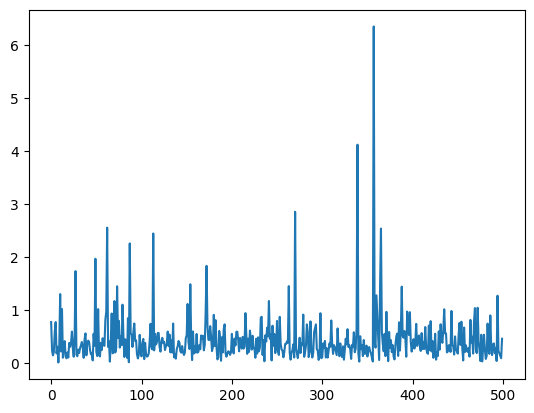

IndexError: index 1 is out of bounds for axis 0 with size 1

In [184]:
svm_model = SVM()
criterion = nn.MSELoss()
optimizer = optim.SGD(svm_model.parameters(), lr=0.001)

num_epochs = 500

losses = []

for epoch in range(num_epochs):
    for data, labels in train_loader:
        optimizer.zero_grad()
        outputs = svm_model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())

    print("Epoch: {}/{} Loss: {:.4f}".format(epoch + 1, num_epochs, loss.item()))

plt.plot(losses)
plt.show()

# Plot the support vectors
plt.scatter(svm_model.linear.weight.detach().numpy()[0], svm_model.linear.weight.detach().numpy()[1])
plt.show()